# Statistics and Inverse Problems 2025
## Exercise 3 -  Glacier gravity profile

### Author(s), contact(s), and dates:
- Author: Valentina Espinoza Fernández (University of Copenhagen), Klaus Mosegaard (Niels Bohr Institute)
- Email:  vf@ign.ku.dk
- Date:   10th of January 2025

# Tabel of contents
* [Problem setup](#problem-setup)
* [Discretized Problem](#discretized-problem)
* [Markov Chain Monte Carlo](#mcmc)

In this notebook we will work out the depth profile of a glacier from gravity measurements. We will use a Markov Chain Monte Carlo method to iteratively sample the posterior distribution. We will do so by using the Metropolis-Hastings algorithm to accept or reject the proposed models sampled from the prior distribution, based on their likelihood (fit) against the data.

In [1]:
# Public dependencies
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Local dependencies - YOUR COMPUTER
from DEPENDENCIES.e3_dependencies import plot_stations, set_figure, valley_parabola, plot_valley_outline

## Problem Setup <a  class="anchor" id="problem-setup"></a>

In [2]:
# Load the observed gravity data

gravdata = np.loadtxt("DATA/gravdata.txt")
x_obs = gravdata[:, 0]           # horizontal coordinate for each observation (in m)
d_obs = gravdata[:, 1] * 1e-5    # horizontal gravity anomaly (in m/s2)
n_stat = len(d_obs)              # Number of stations of observation

# Data covariance matrix
std_d = 1.2 * 1e-5                              # data standard deviation (in m/s2)
cov_d = np.identity(n_stat) * std_d**2          # data covariance matrix 

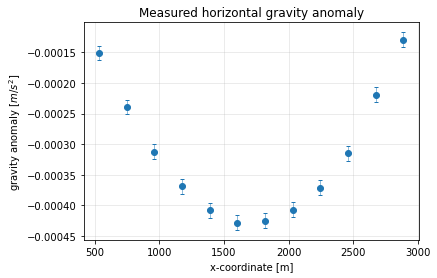

In [3]:
# Plot the gravity data

fig, ax = plt.subplots(figsize=(6,4))
ax.grid(lw=0.5, alpha=0.5)
ax.errorbar(x_obs, d_obs, std_d, capsize=2, fmt="o", elinewidth=0.5)
ax.set(xlabel = 'x-coordinate [m]',
       ylabel = 'gravity anomaly [$m/s^2$]',
       title = 'Measured horizontal gravity anomaly'
);

In [4]:
# Some model parameters

x0 = 425            # leftmost outcrop of the valley
xn = 3000           # rightmost outcrop of the valley
d_density = -1733   # density contrast (kg/m3)
G_grav = 6.67e-11   # gravitational constant (in m3 kg-1 s-2)

## Discretized Model <a  class="anchor" id="discretized-problem"></a>

The relation between gravity anomaly data point $\Delta g_j$ and the model parameter $h(x)$ is given by:
$$ \Delta g_j = \Delta g(x_j) = G\Delta\rho \int_0^a ln \left( \frac{(x-x_j)^2 + h(x)^2}{(x-x_j)^2}\right) dx $$

which can be discretized into M rectangles with width $\Delta x$ and midpoints at $x_i$:

$$ \Delta g_j = G\Delta\rho \sum_{i=1}^M ln \left( \frac{(x_i-x_j)^2 + h(x_i)^2}{(x_i-x_j)^2 + \delta} \right) \Delta x $$

where the inclusion of $\delta$ prevents numerical problems in the denominator of the logarithm.

1. Is this problem linear?

In [5]:
# Calculate g(m) from the given array of thicknesses (m0).
def calculate_g_m(m0, m0_x, x_obs, x_width):
    delta = 1e-15
    grav_l = np.zeros(n_stat)
    
    for j in range(n_stat):
        
        grav_anom = 0
        for l in range(len(m0_x)): 
            grav_anom += G_grav * d_density * np.log(( (m0_x[l] - x_obs[j])**2 + m0[l]**2 ) / ((m0_x[l] - x_obs[j])**2 + delta)) * x_width
            
        grav_l[j] = grav_anom
        
    return grav_l

We take as a preferred model a parabola-shaped valley which contains the ice-sheet. Of our choice is the amount of model parameters, which translates into the amount of *columns* with which we will attempt to model the valley. The more columns (`n_model`) you use, the easier will be to fit the simulated data, but the computation will take longer. A suggested value is **18**, but do see how the valley and simulated data changes when tweaking this parameter.

In [6]:
n_model = 18

m0, m0_x, m0_std, x_width = valley_parabola(n_model, x0, xn)

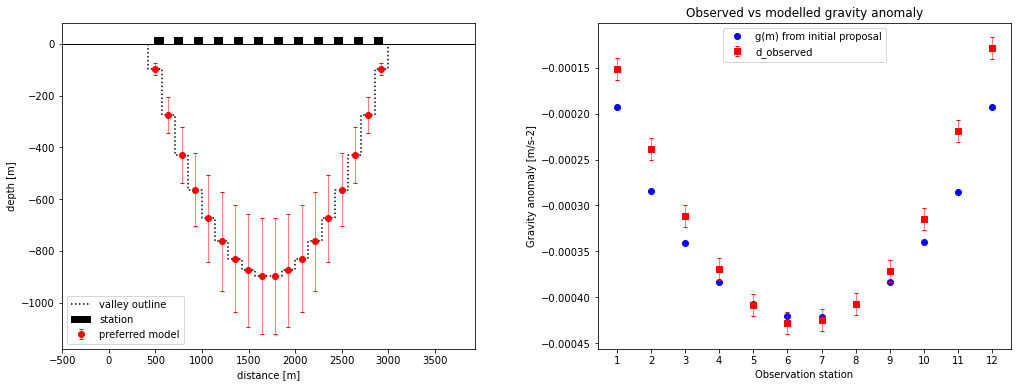

In [7]:
# Plot initial (prior) model 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6), gridspec_kw={"wspace":0.3})

# Plot ice-sheet thickness (m - model parameters)
plot_valley_outline(ax1, m0_x, m0, x_width, label='valley outline')
ax1.errorbar(m0_x, -m0, m0_std, capsize=2, fmt="o", color='r', elinewidth=0.5, label="preferred model")
plot_stations(ax1, x_obs)
set_figure(ax1, m0_x[0], m0_x[-1])
ax1.legend()


# Plot simulated vs observed gravity anomaly (d - data)
ax2.plot(np.arange(1, n_stat+1), calculate_g_m(m0, m0_x, x_obs, x_width), 'ob', label="g(m) from initial proposal")
ax2.errorbar(np.arange(1, n_stat+1), d_obs, std_d, capsize=2, fmt="s", color='r', elinewidth=0.5, label="d_observed")
ax2.set(xticks = np.arange(1, n_stat+1),
       title = "Observed vs modelled gravity anomaly",
       xlabel = "Observation station",
       ylabel = "Gravity anomaly [m/s-2]");
ax2.legend();

2. Try `n_model = 3` and re-run the above cells. Can you predict the pros and cons of few vs many model parameters?

## Markov Chain Monte Carlo  <a  class="anchor" id="mcmc"></a>

We start by defining the the amount of iteration for the MCMC random walk. To test that the acceptance rate is whithin the appropiate range (30-70%), we may start with a low number of iterations (say 10000, `n_size = int(1e4)`). For the final run we can increase this number to `5e4`. This is still low for a MCMC, which would usually do millions iterations, but that would take too long time for this exercise.

In [42]:
n_size = int(1e4)   # size of the model space (number of iterations)

The likelihood expression is given by:
$$ L(m) = \textrm{exp} \left( -\frac{1}{2}(d - g(m))^T C_d^{-1}(d - g(m)) \right)$$

where $C_d$ is the data (noise) covariance matrix, and g(m) is the forward function.

In [43]:
# Estimate the likelihood of the simulated data given the observed data
def likelihood(d_obs, g_m):
    const = 1
    diff = d_obs - g_m
    return const * np.exp(-1/2 * np.dot(np.dot(diff.T, np.linalg.inv(cov_d)), diff))

We will employ a Metropolis algorithm, like so: 

At each step we will propose a new model by randomly perturbing one model parameter by assigning it a new value according to the prior. If the likelihood ($L(m)$) of this new model improves, we keep it as the new current model. If not, we will randomly accept/reject the model against a uniform distribution. This will improve our chance of sampling the whole posterior.

In [44]:
i_m_rand = np.random.randint(0, n_model, n_size)       # ensemble of model parameter indices to change at each iteration
u_rand = np.random.uniform(0, 1, n_size)               # ensemble of vs to accept against

In [45]:
# Perturb the current model, by changing a given model parameter (m0[i_m]) to a new value sampled from the prior (np.random.normal(m0[i_m], m0_std[i_m])).

def perturb_model(m0, m0_std, m_cur, i_m):
    new_m = copy.deepcopy(m_cur)
    new_m[i_m] = np.random.normal(m0[i_m], m0_std[i_m])
    return new_m


Solutions are therefore sampled at a rate proportional to their *a posteriori* probabilities, that is, models consistent with *a priori* information as well as observations are picked most often, whereas models that are in incompatible with either *a priori* information or observations (or both) are
rarely sampled.

## Main Loop

In [46]:
# Setup empty arrays to hold iterative data
m_space = np.zeros((n_model, n_size))
g_m_space = np.zeros((n_stat, n_size))
accept_ratio = np.zeros(n_size)
likelihood_space = np.zeros(n_size)

In [47]:
# Main loop

# Set off with m0 as the current model
m_current = m0     
g_m_current = calculate_g_m(m_current, m0_x, x_obs, x_width)
L_current = likelihood(d_obs, g_m_current)

n_accept = 0       # accepted models count

for i in range(n_size):
    
    # Perturb current model
    m_perturb = perturb_model(m0, m0_std, m_current, i_m_rand[i])
    g_m_perturb = calculate_g_m(m_perturb, m0_x, x_obs, x_width)
    L_perturb = likelihood(d_obs, g_m_perturb)


    # Accept/reject perturbed model
    if u_rand[i] < L_perturb/L_current:
        
        # Update to new model
        m_current = m_perturb
        g_m_current = g_m_perturb
        L_current = L_perturb
        
        n_accept += 1


    # Store current model space
    m_space[:, i] = m_current
    g_m_space[:, i] = g_m_current
    likelihood_space[i] = L_current
    accept_ratio[i] = n_accept/(i+1)

## Results

In [48]:
print("P_accepted percentage: ", n_accept/n_size * 100, "%")

P_accepted percentage:  41.88 %


For further diagnostics, we want to plot the evolution of the acceptance ratio and likelihood with each subsequent iteration. A reasonable run should show:
- An acceptance rate that quickly progressing  that eventually stalls, and
- A likelihood (or log-likelihood) that approaches zero but may wander around low values.

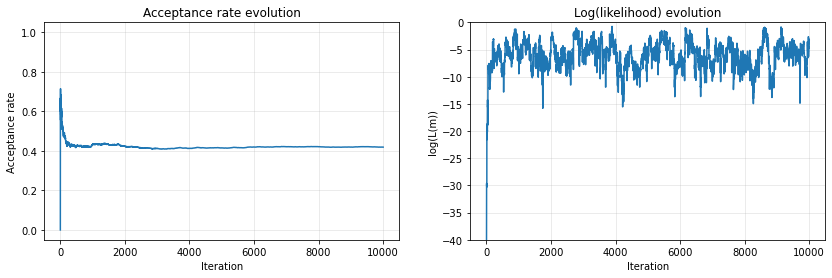

In [49]:
# Plot walk diagnostics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14, 4))

# Acceptance rate
ax1.plot(np.arange(0, n_size), accept_ratio)
ax1.grid(lw=0.5, alpha=0.5)
ax1.set(ylabel = "Acceptance rate", 
        xlabel = "Iteration",
        title = "Acceptance rate evolution",
        ylim = [-0.05, 1.05],
);


# Data fit
ax2.plot(np.arange(0, n_size), np.log(likelihood_space))
ax2.grid(lw=0.5, alpha=0.5)
ax2.set(ylabel = "log(L(m))", 
        xlabel = "Iteration",
        title = "Log(likelihood) evolution",
        ylim=(-40, 0)
);

Based on the plots above, we determine that the first 1000 values are what is called the burn-in, i.e., the part of the walk before reaching the low-misfit area of the posterior. These are discarted from the final data.

In [50]:
burn_in = 1000      # transient iterations

With that in mind, we may visualize the posterior distribution of model parameters and the simulated data that comes from it. For easiness, we will only plot the mean and standard deviation of the distributions.

In [51]:
g_m_data = pd.DataFrame()
g_m_data["station"] = np.arange(1, n_stat+1)

for index, row in g_m_data.iterrows():
    
    rect_data = [g_m_space[index,j] for j in range(n_size)][burn_in:]
    g_m_data.loc[index, "mean"] = np.mean(rect_data)
    g_m_data.loc[index, "std"] = np.std(rect_data)

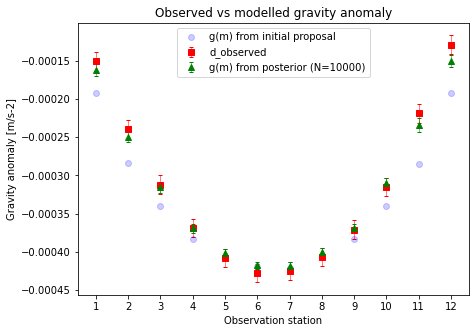

In [52]:
# Plot simulated vs observed gravity anomaly (d - data)

fig, ax = plt.subplots(figsize =(7,5))

# Observed data
ax.errorbar(np.arange(1, n_stat+1), d_obs, std_d, capsize=2, fmt="s", color='r', elinewidth=0.5, label="d_observed")

# Initial model proposal (prior)
ax.plot(np.arange(1, n_stat+1), calculate_g_m(m0, m0_x, x_obs, x_width), 'ob', alpha=0.2, label="g(m) from initial proposal")

# g(m) from posterior distribution
ax.errorbar(g_m_data["station"], g_m_data["mean"], g_m_data["std"], capsize=2, fmt="^", color='g', elinewidth=0.5, label="g(m) from posterior (N=%s)" %n_size)

ax.set(xticks = np.arange(1, n_stat+1),
       title = "Observed vs modelled gravity anomaly",
       xlabel = "Observation station",
       ylabel = "Gravity anomaly [m/s-2]");

ax.legend();

In [53]:
posterior_data = pd.DataFrame()
posterior_data["column"] = np.arange(1, n_model+1)

for index, row in posterior_data.iterrows():
    
    rect_data = [m_space[index,j] for j in range(n_size)][burn_in:]
    posterior_data.loc[index, "mean"] = np.mean(rect_data)
    posterior_data.loc[index, "std"] = np.std(rect_data)

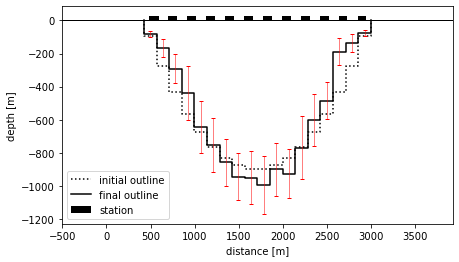

In [54]:
# Plot ice-sheet thickness (m - model parameters)

fig, ax = plt.subplots(figsize=(7,4))

plot_valley_outline(ax, m0_x, m0, x_width, label='initial outline')
plot_valley_outline(ax, m0_x, posterior_data["mean"], x_width, label='final outline', linestyle='-')
ax.errorbar(m0_x, -posterior_data["mean"], posterior_data["std"], capsize=2, fmt="none", ecolor='r', elinewidth=0.5)

plot_stations(ax, x_obs)
set_figure(ax, m0_x[0], m0_x[-1])
ax.legend();

Since we do have the full space of models, we may plot the frequency of thicknesses for the discretized ice-sheet columns (posterior distribution).

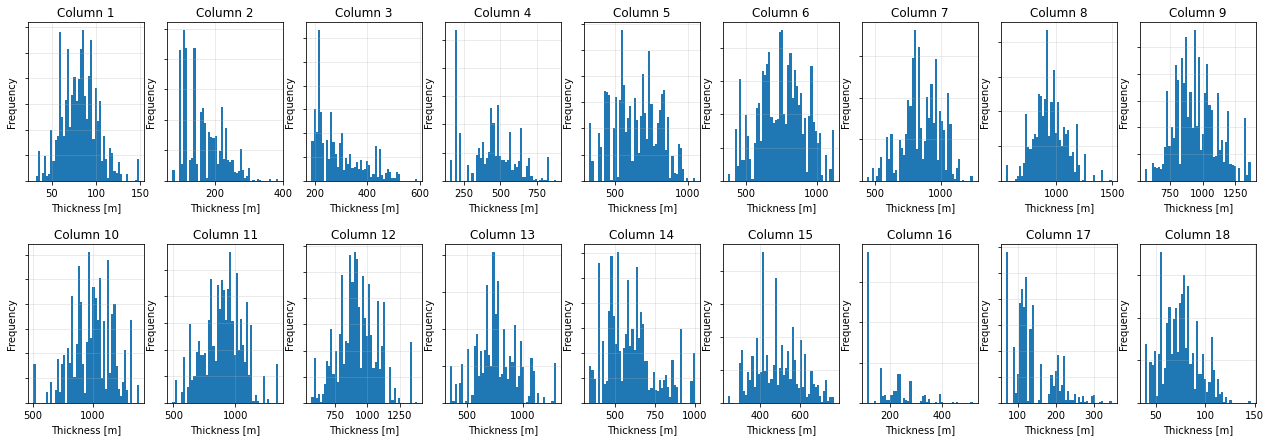

In [55]:
# Plot frequency of thickness for each column (meant for 18 columns!)

fig, ax = plt.subplots(2, 9, figsize =(22,7), gridspec_kw=dict(wspace=0.2, hspace=0.4))
axes = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8),
        (1,0), (1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)]


for n in range(n_model):
    data = [m_space[n,j] for j in range(n_size)][burn_in:]
    ax[axes[n]].grid(lw=0.5, alpha=0.5)
    ax[axes[n]].hist(data, bins=50)
    ax[axes[n]].set(title = "Column %s" %(n+1),
                    xlabel = "Thickness [m]",
                    ylabel = "Frequency",
                    yticklabels= [])  